# 1. lstm structure

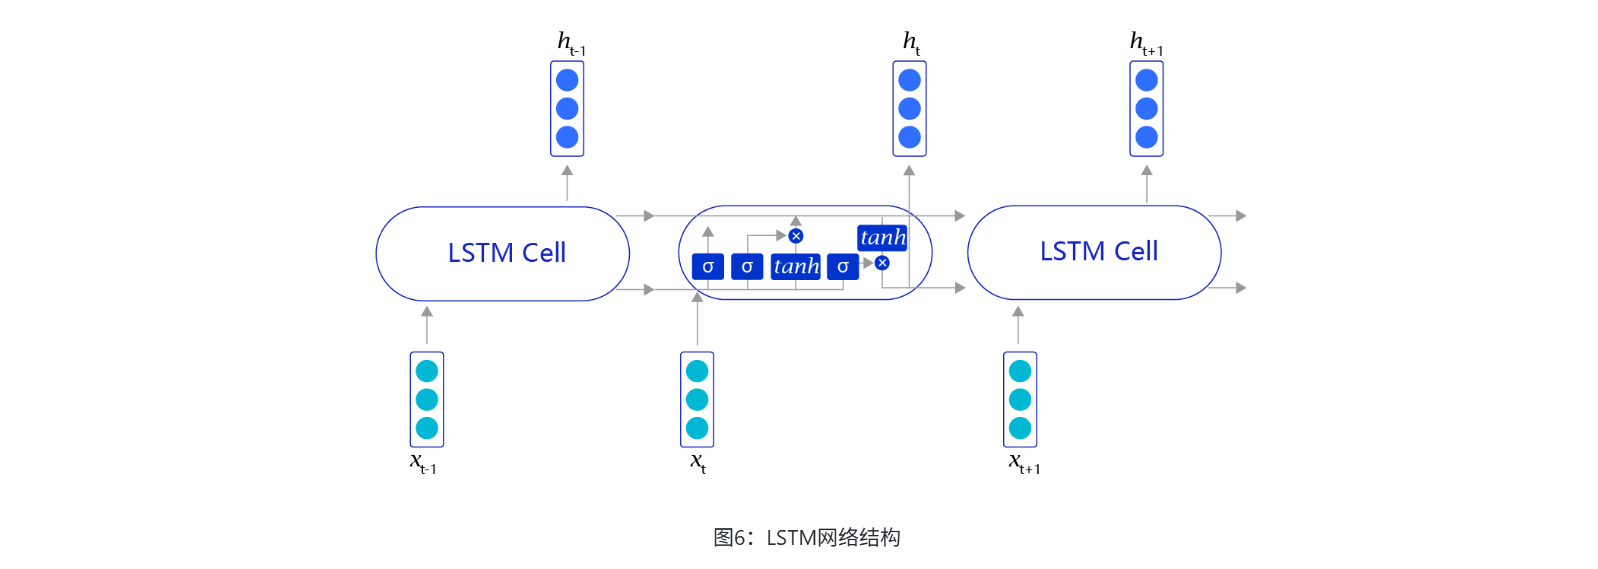

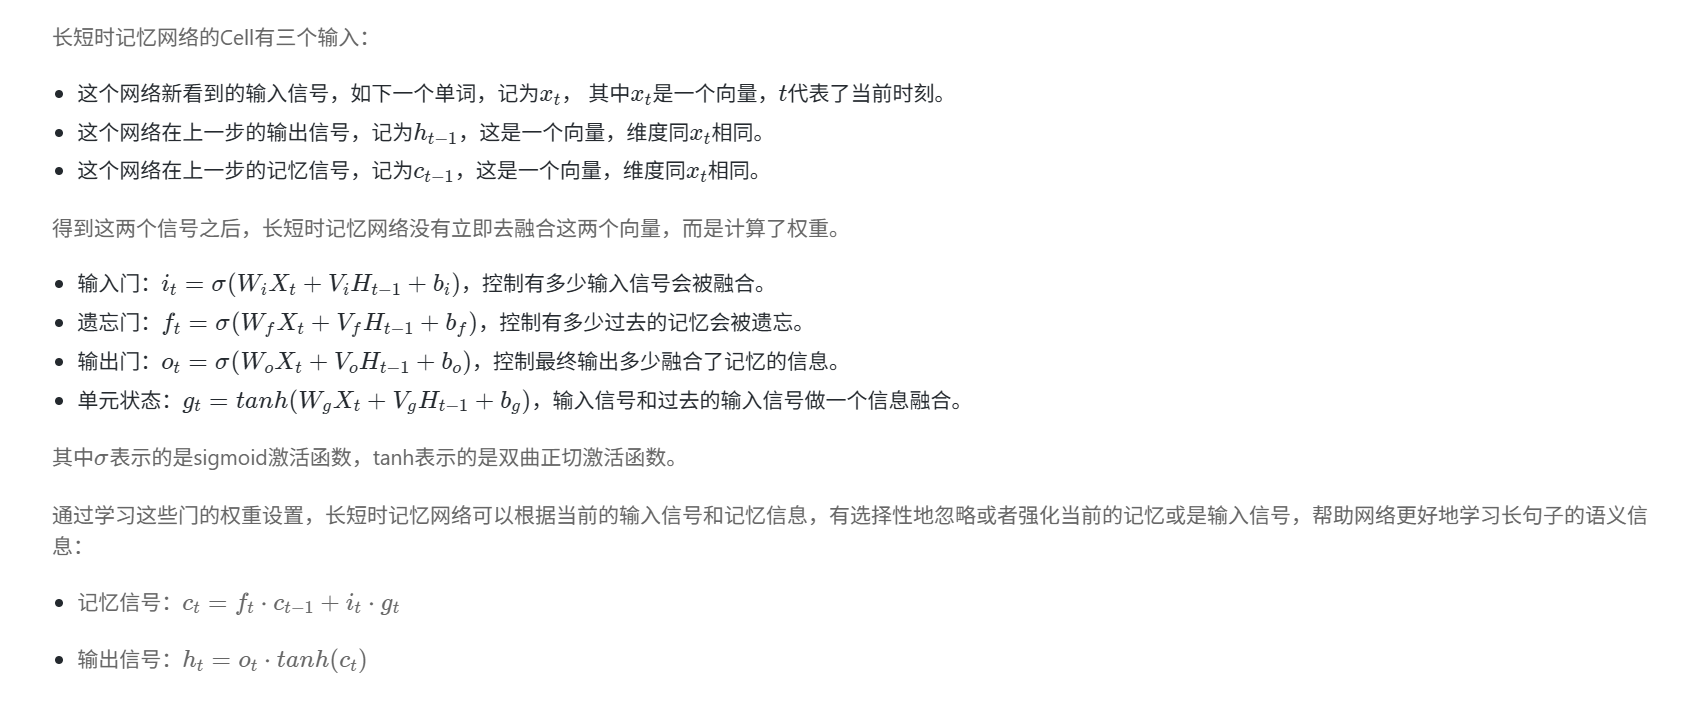

# 2. data processing

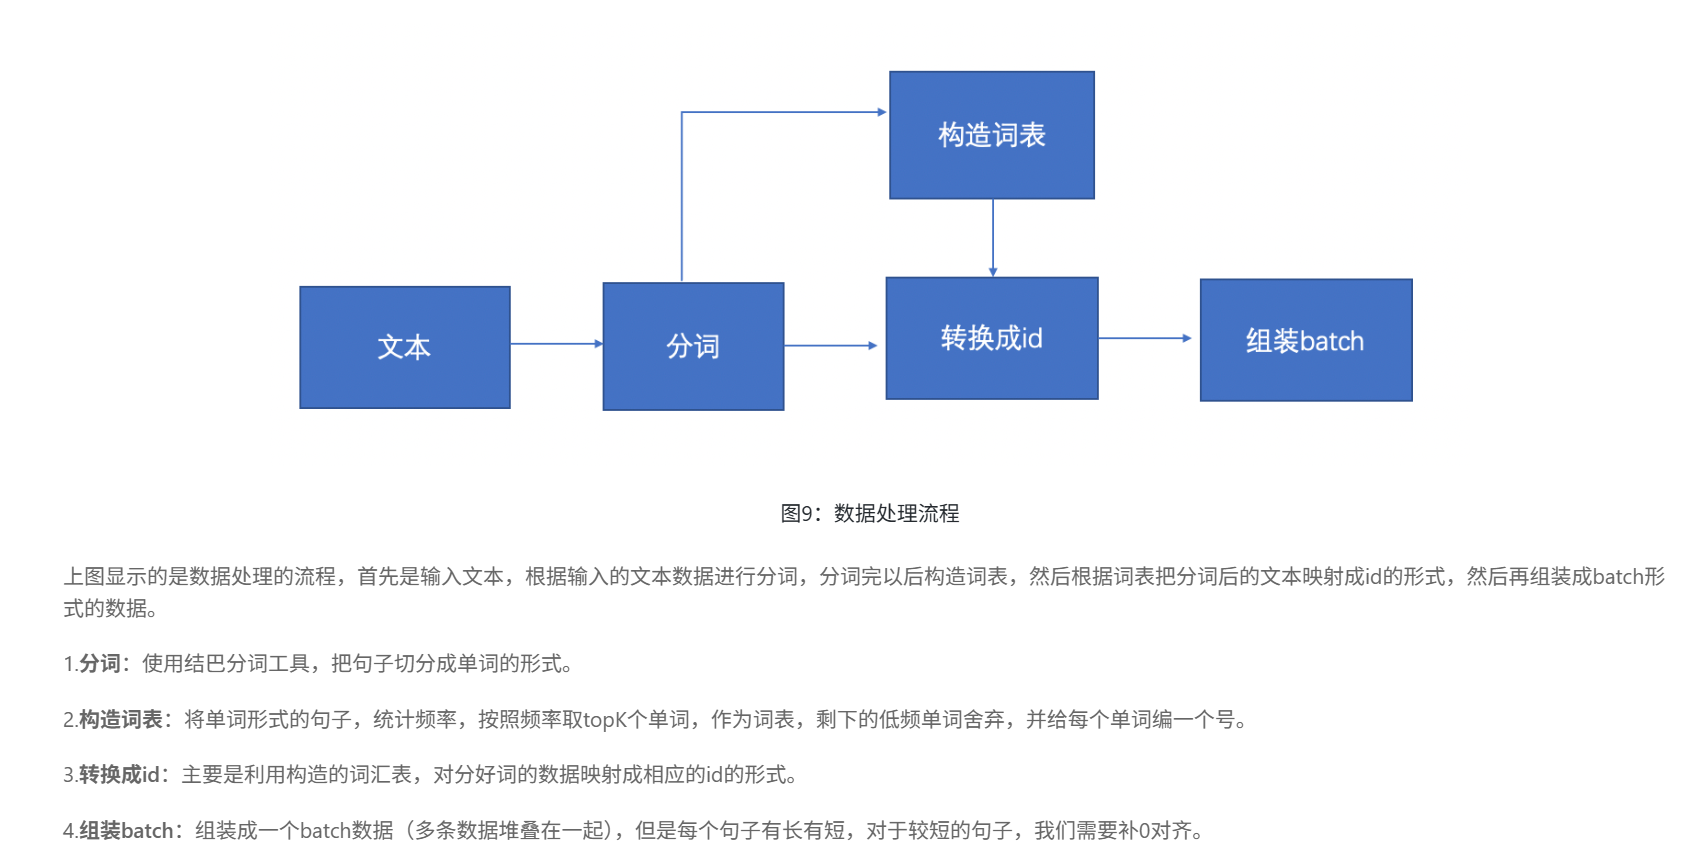

## 2.1 data loader

In [ ]:
import os
import random 
import numpy as np
import pandas as pd
# 导入Paddle的API
import paddle
import paddle.nn as nn
import paddle.nn.functional as F
from paddle.nn import LSTM, Embedding, Dropout, Linear

In [2]:
from paddlenlp.datasets import load_dataset

def read(split='train'):
    data_dict={'train':'ChnSentiCorp/train.tsv',
                "dev":'ChnSentiCorp/dev.tsv',
                'test':'ChnSentiCorp/test.tsv'}
    with open(data_dict[split],'r') as f:
        head = None
        # 一行一行的读取数据
        for line in f.readlines():
            data = line.strip().split("\t")
            # 跳过第一行，因为第一行是列名
            if not head:
                head = data
            else:
                # 从第二行还是一行一行的返回数据
                if split == 'train':
                    label, text = data
                    yield {"text": text, "label": label, "qid": ''}
                elif split == 'dev':
                    qid, label, text = data
                    yield {"text": text, "label": label, "qid": qid}
                elif split == 'test':
                    qid, text = data
                    yield {"text": text, "label": '', "qid": qid}


train_ds= load_dataset(read, split="train",lazy=False)
dev_ds= load_dataset(read, split="dev",lazy=False)
test_ds= load_dataset(read, split="test",lazy=False)

In [3]:
for data in train_ds.data[:5]:
    print(data)

{'text': '选择珠江花园的原因就是方便，有电动扶梯直接到达海边，周围餐馆、食廊、商场、超市、摊位一应俱全。酒店装修一般，但还算整洁。 泳池在大堂的屋顶，因此很小，不过女儿倒是喜欢。 包的早餐是西式的，还算丰富。 服务吗，一般', 'label': '1', 'qid': ''}
{'text': '15.4寸笔记本的键盘确实爽，基本跟台式机差不多了，蛮喜欢数字小键盘，输数字特方便，样子也很美观，做工也相当不错', 'label': '1', 'qid': ''}
{'text': '房间太小。其他的都一般。。。。。。。。。', 'label': '0', 'qid': ''}
{'text': '1.接电源没有几分钟,电源适配器热的不行. 2.摄像头用不起来. 3.机盖的钢琴漆，手不能摸，一摸一个印. 4.硬盘分区不好办.', 'label': '0', 'qid': ''}
{'text': '今天才知道这书还有第6卷,真有点郁闷:为什么同一套书有两种版本呢?当当网是不是该跟出版社商量商量,单独出个第6卷,让我们的孩子不会有所遗憾。', 'label': '1', 'qid': ''}


In [4]:
from collections import defaultdict
import jieba
from paddlenlp.data import Vocab

# 一个特殊的单词"[UNK]"，用于表示词表中没有覆盖到的词。之所以使用"[UNK]"这个符号，是为了处理某一些词，在测试数据中有，但训练数据没有的现象。

def build_vocab(texts,
                stopwords=[],
                num_words=None,
                min_freq=10,
                unk_token="[UNK]",
                pad_token="[PAD]"):
    word_counts = defaultdict(int)
    for text in texts:
        if not text:
            continue
        # # 统计词频
        # 一般来说，在自然语言处理中，需要先对语料进行切词，英文可以使用空格把每个句子切成若干词的序列
        # 对于中文则需要使用结巴分词进行切分
        for word in jieba.cut(text):
            if word in stopwords:
                continue
            word_counts[word] += 1
    # 过滤掉词频小于min_freq的单词
    wcounts = []
    for word, count in word_counts.items():
        if count < min_freq:
            continue
        wcounts.append((word, count))
    # 把单词按照词频从大到小进行排序
    wcounts.sort(key=lambda x: x[1], reverse=True)
    
    # 限制词表大小
    # 如果指定了 num_words，并且排序后的单词数量大于 num_words - 2，
    # 则截取前 num_words - 2 个单词。这里减去 2 是因为后面会加入两个特殊标记：pad_token 和 unk_token。
    if num_words is not None and len(wcounts) > (num_words - 2):
        wcounts = wcounts[:(num_words - 2)]
        
    # 初始化词汇表列表 sorted_voc，先加入两个特殊标记 pad_token 和 unk_token。
    # 然后将排序后的单词依次加入到词汇表中。
    sorted_voc = [pad_token, unk_token]
    sorted_voc.extend(wc[0] for wc in wcounts)
    # 给每个单词一个编号
    # 使用 zip 将词汇表中的单词与它们的索引（从 0 开始）配对，生成一个字典 word_index，其中键是单词，值是对应的编号。
    word_index = dict(zip(sorted_voc, list(range(len(sorted_voc)))))
    return word_index

texts = []
for data in train_ds:
    texts.append(data["text"])
for data in dev_ds:
    texts.append(data["text"])

# 以下停用词仅用作示例，具体停用词的选择需要根据具体语料库调整。
stopwords = set(["的", "吗", "吧", "呀", "呜", "呢", "呗"])
# 构建词汇表
word2idx = build_vocab(
    texts, stopwords, min_freq=5, unk_token="[UNK]", pad_token="[PAD]")
vocab = Vocab.from_dict(word2idx, unk_token="[UNK]", pad_token="[PAD]")
# 保存词汇表
res=vocab.to_json("./vocab.json")

Building prefix dict from the default dictionary ...
[2025-11-16 09:50:56,302] [   DEBUG] __init__.py:113 - Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
[2025-11-16 09:50:56,303] [   DEBUG] __init__.py:132 - Loading model from cache /tmp/jieba.cache
Loading model cost 0.652 seconds.
[2025-11-16 09:50:56,955] [   DEBUG] __init__.py:164 - Loading model cost 0.652 seconds.
Prefix dict has been built successfully.
[2025-11-16 09:50:56,956] [   DEBUG] __init__.py:166 - Prefix dict has been built successfully.


### 2.1.1 分词并转换成id

In [5]:
from paddlenlp.data import JiebaTokenizer

def get_idx_from_word(word, word_to_idx, unk_word):
    if word in word_to_idx:
        return word_to_idx[word]
    return word_to_idx[unk_word]

# 把词汇表加载到结巴分词器中
tokenizer = JiebaTokenizer(vocab)
text='选择珠江花园的原因就是方便，有电动扶梯直接到达海边，周围餐馆、食廊、商场、超市、摊位一应俱全。'
segment_text=tokenizer.cut(text)
print("分词后的文本:{}".format(segment_text))
input_ids = [get_idx_from_word(word,vocab.token_to_idx,vocab.unk_token) for word in segment_text]
print("把分词后的文本转换成id:{}".format(input_ids))

input_ids = tokenizer.encode(text)
print("encode 编码后的id: {}".format(input_ids))

分词后的文本:['选择', '珠江', '花园', '的', '原因', '就是', '方便', '，', '有', '电动', '扶梯', '直接', '到达', '海边', '，', '周围', '餐馆', '、', '食廊', '、', '商', '场', '、', '超市', '、', '摊位', '一应', '俱全', '。']
把分词后的文本转换成id:[198, 1, 1595, 1, 406, 38, 105, 2, 16, 1, 1, 349, 987, 1699, 2, 663, 3103, 26, 1, 26, 1, 6212, 26, 1453, 26, 1, 1, 1, 3]
encode 编码后的id: [198, 1, 1595, 1, 406, 38, 105, 2, 16, 1, 1, 349, 987, 1699, 2, 663, 3103, 26, 1, 26, 1, 6212, 26, 1453, 26, 1, 1, 1, 3]


In [6]:
from functools import partial

# 把语料转换为id序列
def convert_example(example, tokenizer, is_test=False):
    # 将句子中的词逐个替换成id，如果句子中的词不在词表内，则替换成[UNK]
    input_ids = tokenizer.encode(example["text"])
    # 计算出数据转换成id后的长度，并转换成numpy的格式
    valid_length = np.array(len(input_ids), dtype='int64')
    # 把id形式的数据转换成numpy的形式
    input_ids = np.array(input_ids, dtype='int64')
    # 训练集需要label
    if not is_test:
        label = np.array(example["label"], dtype="int64")
        return input_ids, valid_length, label
    else:
        # 测试集不需要label
        return input_ids, valid_length

# partial函数的意思是把tokenizer=tokenizer, is_test=False赋值给当前的convert_example函数
trans_fn = partial(convert_example, tokenizer=tokenizer, is_test=False)
# 训练数据转换成id的形式
train_ds = train_ds.map(trans_fn)
# 验证集转换成id的形式
dev_ds = dev_ds.map(trans_fn)

### 2.1.2 组装minibatch

接下来，我们就可以开始把原始语料中的每个句子通过截断和填充，转换成一个固定长度的句子，并将所有数据整理成mini-batch，用于训练模型，代码如下：

在组装minit-batch数据之前，我们先介绍一下需要使用的API，Stack, Pad, Tuple，Stack的功能是把向量堆叠在一起，Pad的功能是把不同长度的向量填充补齐，Tuple的功能是将多个batchify函数（比如Pad，Stack）包装在一起，示例如下

In [7]:
from paddlenlp.data import Stack, Pad, Tuple

# 构建a，b，c三个向量
a = [1, 2, 3, 4]
b = [3, 4, 5, 6]
c = [5, 6, 7, 8]
result = Stack()([a, b, c])
print("堆叠（Stacked）数据后 : \n", result)
print()

# 构建a，b，c三个向量
a = [1, 2, 3, 4]
b = [5, 6, 7]
c = [8, 9]
result = Pad(pad_val=0)([a, b, c])
print("对齐（Padded）数据后: \n", result)
print()

# 构造一个小的样本，包含输入id和label
data = [
        [[1, 2, 3, 4], [1]],
        [[5, 6, 7], [0]],
        [[8, 9], [1]],
       ]
batchify_fn = Tuple(Pad(pad_val=0), Stack())
ids, labels = batchify_fn(data)
print("id的输出: \n", ids)
print()
print("标签的输出: \n", labels)
print()

堆叠（Stacked）数据后 : 
 [[1 2 3 4]
 [3 4 5 6]
 [5 6 7 8]]

对齐（Padded）数据后: 
 [[1 2 3 4]
 [5 6 7 0]
 [8 9 0 0]]

id的输出: 
 [[1 2 3 4]
 [5 6 7 0]
 [8 9 0 0]]

标签的输出: 
 [[1]
 [0]
 [1]]



In [8]:
batch_size = 64
batchify_fn = lambda samples, fn=Tuple(
    Pad(axis=0, pad_val=vocab.token_to_idx.get('[PAD]', 0)),  # 表示在一个mini-batch与最长的那条数据对齐，长度不够的话用0来补齐
    Stack(dtype="int64"),  # seq len
    Stack(dtype="int64")  # label
): [data for data in fn(samples)]

# 训练集的sampler，迭代式获取mini-batch的样本下标数组，数组长度与 batch_size 一致
train_sampler = paddle.io.BatchSampler(
            dataset=train_ds, batch_size=batch_size, shuffle=True)
# 测试集的sampler，迭代式获取mini-batch的样本下标数组，数组长度与 batch_size 一致
test_sampler = paddle.io.BatchSampler(
            dataset=dev_ds, batch_size=batch_size, shuffle=True)
# 使用paddle.io.DataLoader接口多线程异步加载数据
# DataLoader根据 batch_sampler 给定的顺序迭代一次给定的 dataset
train_loader = paddle.io.DataLoader(
        train_ds, batch_sampler=train_sampler, collate_fn=batchify_fn)
# 使用验证集作为测试集，因为验证集包含label。而原来的测试集没有label，不方便算指标
test_loader = paddle.io.DataLoader(
        dev_ds, batch_sampler=test_sampler, collate_fn=batchify_fn)
# 打印输出一个mini-batch的数据
for idx,item in enumerate(train_loader):
    if(idx==0):
        print(item)
        # break

[Tensor(shape=[64, 226], dtype=int64, place=Place(cpu), stop_gradient=True,
       [[1   , 614 , 2   , ..., 0   , 0   , 0   ],
        [548 , 6   , 21  , ..., 0   , 0   , 0   ],
        [225 , 20  , 25  , ..., 0   , 0   , 0   ],
        ...,
        [281 , 19  , 111 , ..., 0   , 0   , 0   ],
        [1052, 108 , 8732, ..., 0   , 0   , 0   ],
        [13  , 281 , 52  , ..., 0   , 0   , 0   ]]), Tensor(shape=[64], dtype=int64, place=Place(cpu), stop_gradient=True,
       [110, 52 , 33 , 44 , 37 , 138, 27 , 25 , 76 , 120, 67 , 44 , 58 , 136,
        110, 116, 33 , 65 , 28 , 64 , 15 , 28 , 115, 39 , 93 , 157, 75 , 31 ,
        27 , 110, 29 , 28 , 107, 28 , 32 , 25 , 32 , 62 , 55 , 64 , 190, 24 ,
        108, 128, 125, 18 , 60 , 53 , 226, 107, 76 , 114, 61 , 77 , 59 , 118,
        20 , 30 , 23 , 28 , 124, 47 , 26 , 62 ]), Tensor(shape=[64], dtype=int64, place=Place(cpu), stop_gradient=True,
       [1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 1, 0

迭代器的输出，可以看到输出的数据
第一个Tensor中的batch size的大小是64，每条数据的长度是432；
第二个Tensor存放的是每条数据实际长度，超长的做clip，短的做padding
第三个Tensor表示的是每条数据的label，总共64个label。

## 3. 网络定义

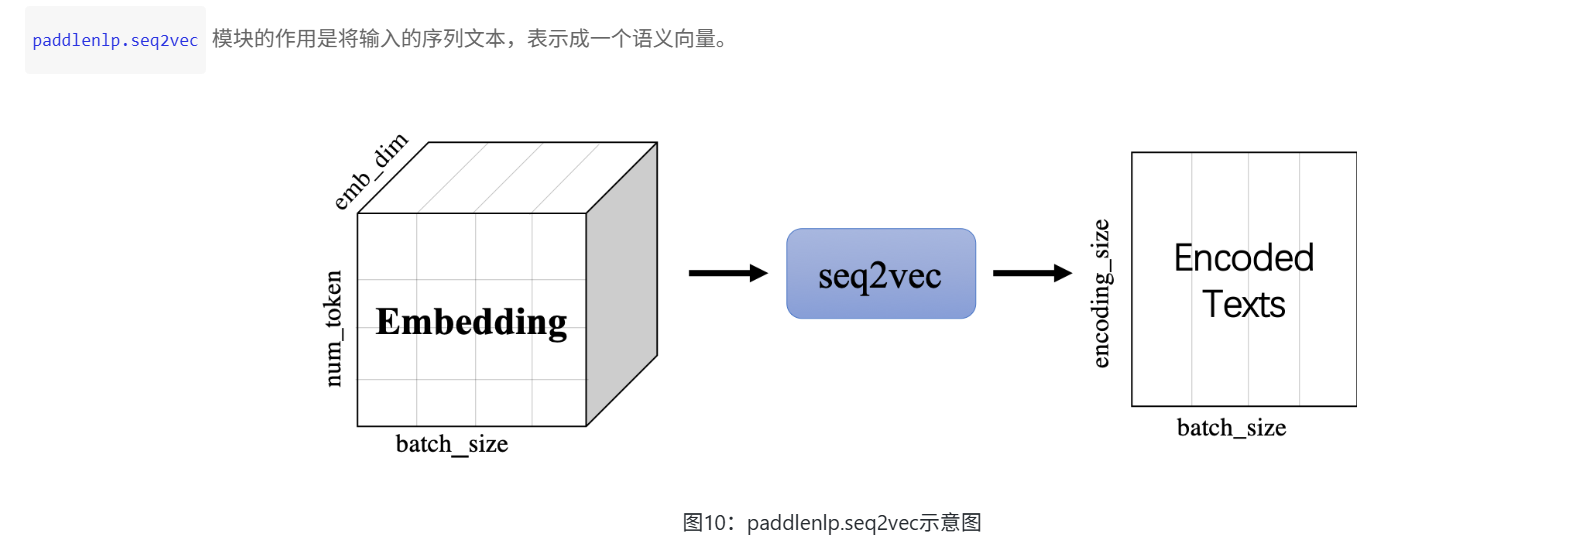

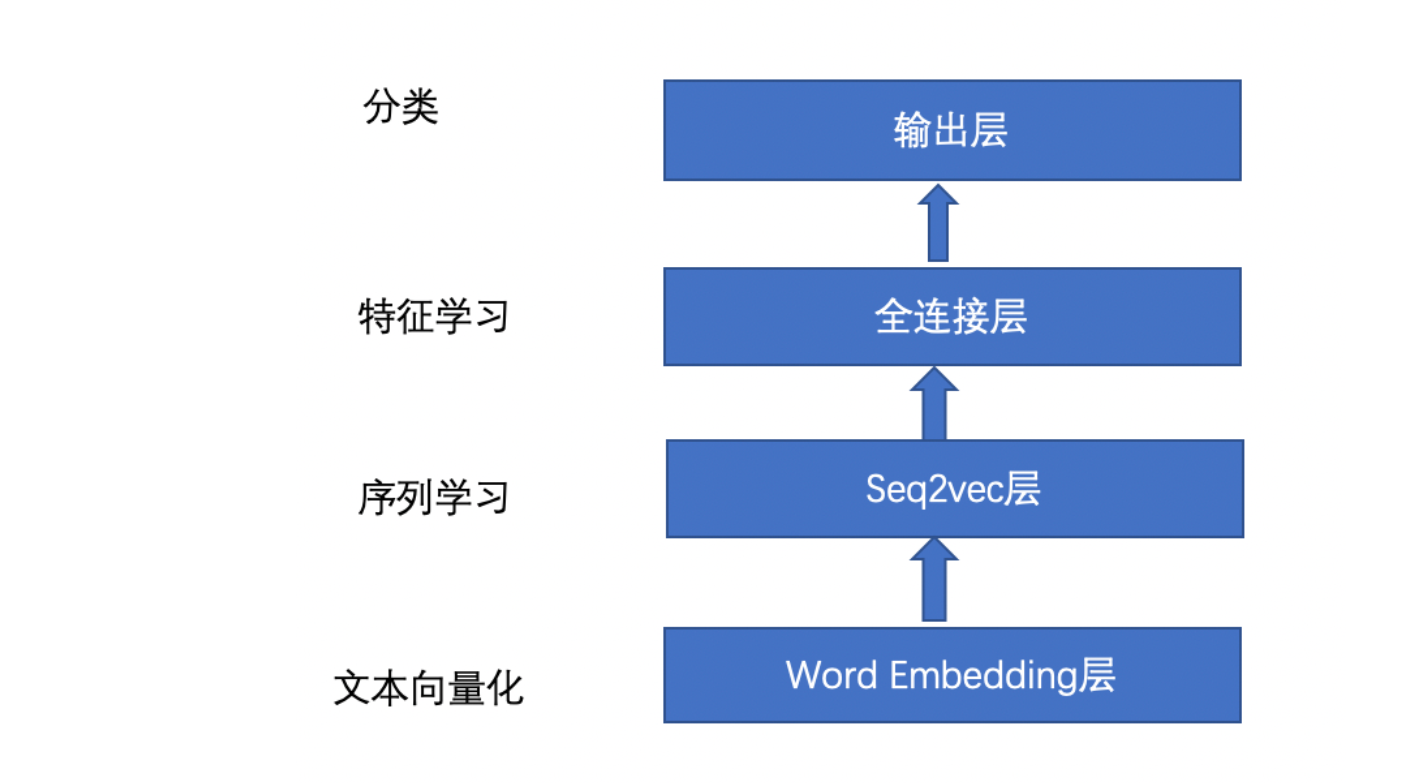

# 4. 模型训练

## 4.1 模型网络结构设计
情感分析网络

1.文本向量化：这部分的作用就是把文本id的形式转换成稠密的向量的形式；

2.序列学习：序列学习是seq2vec层，具体使用的是双向LSTM用来学习文本序列的相关关系；

3.特征学习：特征学习使用了全连接层，主要是对前面的序列特征进一步学习，得到全局的特征信息；

4.分类：分类是输出层，本质上是一个全连接层，主要是把特征转化成情感类别概率输出。

In [9]:
import paddlenlp as ppnlp

class LSTMModel(nn.Layer):
    def __init__(self,
                 vocab_size,
                 num_classes,
                 emb_dim=128,
                 padding_idx=0,
                 lstm_hidden_size=198,
                 direction='forward',
                 lstm_layers=1,
                 dropout_rate=0.0,
                 pooling_type=None,
                 fc_hidden_size=96):
        super().__init__()
        # 1. 文本向量化
        # 首先将输入word id 查表后映射成 word embedding
        self.embedder = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=emb_dim,
            padding_idx=padding_idx)
        
        # 2. 序列学习 seq2vec层，具体使用的是双向LSTM用来学习文本序列的相关关系
        # 将word embedding经过LSTMEncoder变换到文本语义表征空间中
        self.lstm_encoder = ppnlp.seq2vec.LSTMEncoder(
            emb_dim,
            lstm_hidden_size,
            num_layers=lstm_layers,
            direction=direction,
            dropout=dropout_rate,
            pooling_type=pooling_type)
        
        # 3.特征学习 特征学习使用了全连接层，主要是对前面的序列特征进一步学习，得到全局的特征信息
        # LSTMEncoder.get_output_dim()方法可以获取经过encoder之后的文本表示hidden_size
        self.fc = nn.Linear(self.lstm_encoder.get_output_dim(), fc_hidden_size)
        
        # 4. 输出层 分类是输出层，本质上是一个全连接层，主要是把特征转化成情感类别概率输出。
        # 最后的分类器
        self.output_layer = nn.Linear(fc_hidden_size, num_classes)

    # forwad函数即为模型前向计算的函数，它有两个输入，分别为：
    # input为输入的训练文本，其shape为[batch_size, max_seq_len]
    # seq_len训练文本对应的真实长度，其shape维[batch_size]
    def forward(self, text, seq_len):
        # 输入的文本的维度(batch_size, num_tokens, embedding_dim)
        embedded_text = self.embedder(text)
        # lstm的输出的维度: (batch_size, num_tokens, num_directions*lstm_hidden_size)
        # 如果lstm是双向的，则num_directions = 2，如果是单向的则num_directions的维度是1
        text_repr = self.lstm_encoder(embedded_text, sequence_length=seq_len)
        # 全连接层的的维度是(batch_size, fc_hidden_size)
        fc_out = paddle.tanh(self.fc(text_repr))
        # 输出层的维度(batch_size, num_classes)
        logits = self.output_layer(fc_out)
        # probs 分类概率值
        probs = F.softmax(logits, axis=-1)
        return probs

## 4.2 模型训练

In [10]:
# 定义训练参数
epoch_num = 4
batch_size = 128

learning_rate = 5e-5
dropout_rate = 0.2
num_layers = 1
hidden_size = 256
embedding_size = 256
vocab_size=len(vocab)
print(vocab_size)
# 实例化LSTM模型
model= LSTMModel(
        vocab_size,
        num_classes=2,
        emb_dim=embedding_size,
        lstm_layers=num_layers,
        direction='bidirectional',
        padding_idx=vocab['[PAD]'])
# 指定优化策略，更新模型参数
optimizer = paddle.optimizer.Adam(learning_rate=learning_rate, beta1=0.9, beta2=0.999, parameters= model.parameters()) 

8911


In [11]:
paddle.device.get_device()


'cpu'

In [ ]:
paddle.seed(0)
random.seed(0)
np.random.seed(0)
# 定义训练函数
# 记录训练过程中的损失变化情况，可用于后续画图查看训练情况
losses = []
steps = []

def train(model):
    # 开启模型训练模式
    model.train()
    
    global_step =  0
    for epoch in range(epoch_num):
        for step, (sentences,valid_length, labels) in enumerate(train_loader):
        
            # 前向计算，将数据feed进模型，并得到预测的情感标签和损失
            logits = model(sentences,valid_length)

            # 计算损失
            loss = F.cross_entropy(input=logits, label=labels, soft_label=False)
            loss = paddle.mean(loss)

            # 反向传播
            loss.backward()
            # 更新参数
            optimizer.step()
            # 清除梯度
            optimizer.clear_grad()
            
            global_step+=1

            if global_step % 100 == 0:
                # 记录当前步骤的loss变化情况
                losses.append(loss.numpy()[0])
                steps.append(step)
                # 打印当前loss数值
                print("epoch %d, step %d, loss %.3f" % (epoch,global_step, loss.numpy()[0]))

#训练模型
train(model)
# 保存模型，包含两部分：模型参数和优化器参数
model_name = "sentiment_classifier"
# 保存训练好的模型参数
paddle.save(model.state_dict(), "checkpoint/{}.pdparams".format(model_name))
# 保存优化器参数，方便后续模型继续训练
paddle.save(optimizer.state_dict(), "checkpoint/{}.pdopt".format(model_name))

In [ ]:
@paddle.no_grad()
def evaluate(model):
    # 开启模型测试模式，在该模式下，网络不会进行梯度更新
    model.eval()

    # 定义以上几个统计指标
    tp, tn, fp, fn = 0, 0, 0, 0
    
    for sentences,valid_lens, labels in test_loader:
    
        # 获取模型对当前batch的输出结果
        logits = model(sentences,valid_lens)
        
        # 使用softmax进行归一化
        probs = F.softmax(logits)

        # 把输出结果转换为numpy array数组，比较预测结果和对应label之间的关系，并更新tp，tn，fp和fn
        probs = probs.numpy()
        for i in range(len(probs)):
            # 当样本是的真实标签是正例
            if labels[i][0] == 1:
                # 模型预测是正例
                if probs[i][1] > probs[i][0]:
                    tp += 1
                # 模型预测是负例
                else:
                    fn += 1
            # 当样本的真实标签是负例
            else:
                # 模型预测是正例
                if probs[i][1] > probs[i][0]:
                    fp += 1
                # 模型预测是负例
                else:
                    tn += 1

    # 整体准确率
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    # 输出最终评估的模型效果
    print("TP: {}\nFP: {}\nTN: {}\nFN: {}\n".format(tp, fp, tn, fn))
    print("Accuracy: %.4f" % accuracy)

# 加载训练好的模型进行预测，重新实例化一个模型，然后将训练好的模型参数加载到新模型里面
state_dict=paddle.load('checkpoint/sentiment_classifier.pdparams')
model.load_dict(state_dict)
# 评估模型
evaluate(model)